In [25]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

In [26]:
# Model is roberta-base, zero-shot and few-shot hybrid
datasets = {"mnli": 0} # "agnews": 1, "mnli": 0, "yahoo": 5, "yelp-full": 0
all_client_num_in_total_list = {"agnews": 100, "yahoo": 1000, "yelp-full": 1000, "mnli": 1000}
alphas = {"agnews": 1, "yahoo": 1, "yelp-full": 0, "mnli": 0}
gammas = {"agnews": 0.001, "yahoo": 0.001, "yelp-full": 100, "mnli": 100}
full_set_acc= {"agnews": 0.93, "yahoo": 0.78, "yelp-full": 0.7, "mnli": 0.85}
train_data = {"agnews": 0, "yahoo": 64}


labels = []
filter = {"agnews": 0.1, "yahoo": 0.1, "yelp-full": 0.5, "mnli": 0.2}
k_list = [1,2,4] # data point
n_list = [1,2,4] # infer client num
f_list = [1,2,4] # infer frequency


seed = 6
# source file/log
root_path = "/Users/cdq/Desktop/opensource/FedPrompt/data/ablation/pacing/pacing-configuration-12.3"
output_fig_path = "/Users/cdq/Desktop/opensource/FedPrompt/figs/pacing"

# plot hyper-para.
colors=['r','g','b','y','c','m','k','purple'] * 100

# per batch latency, bs = 4, msl = 256
train_latency_list = {"tx2+bitfit": 1, "tx2+full": 2}
infer_latency_list = {"tx2+bitfit": 0.5, "tx2+full": 1}
communication_latency_list = {"bitfit": 1000 * 2 / 1000 / 1, "full": 1000 * 2 / 1}

np.random.seed(42)

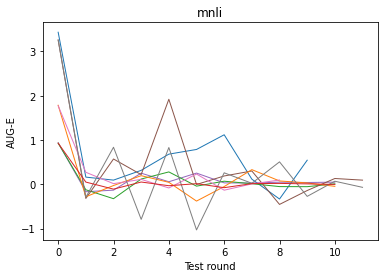

In [32]:
# time to accuracy  
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}    
trial = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}    
test_round = 1
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
for dataset in datasets:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = []
    labels = []
    for k in k_list:
        for n in n_list:
            for f in f_list:
                filenames.append(f"ours++_fedpet_roberta-large_train_examples_64_f_{f}_n_{n}_k_{k}_filter_{filter[dataset]}.log")
                labels.append(f"k={k}, n={n}, f={f}")
    
    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Test round")
    plt.ylabel("AUG-E")
    # plt.ylim(-0.1,0.2)
    filenames_show = np.random.choice(filenames, 8, replace=False).tolist()
    for filename in filenames:
        if filename not in filenames_show:
            continue
        log_path = os.path.join(log_root_path, filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 100
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        train_delta = []
        infer_delta = []
        acc_delta = []
        acc_tmp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                train_samples = list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]
                infer_samples = list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]
                # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                train_time = np.max(train_samples) * train_latency_list["tx2+bitfit"] if len(train_samples) > 0 else 0
                infer_time = np.max(infer_samples) * infer_latency_list["tx2+bitfit"] if len(infer_samples) > 0 else 0

                train_delta.append(train_time)
                infer_delta.append(infer_time)

            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc
                acc_delta.append(acc - acc_tmp)
                acc_tmp = acc
        
        infer_delta = [np.sum(np.array(infer_delta)) / len(infer_delta)] * len(infer_delta) # divide infer time into even time periods
        iter = len(df.index)
        
        # show_iter = 20
        show_iter = min(len(np.array(train_delta)), len(np.array(infer_delta)), len(np.array(acc_delta))) # make sure the length of three lists are the same

        train_gradient = np.array(acc_delta[:show_iter]) / np.array(train_delta[:show_iter])
        infer_gradient = np.array(acc_delta[:show_iter]) / np.array(infer_delta[:show_iter])

        curve = 100*np.array(acc_delta)[:show_iter] / (np.array(train_delta[:show_iter]) + np.array(infer_delta[:show_iter]))

        flag = 0
        curve_average = []
        tmp = 0
        for i in range(show_iter):
            if flag == test_round:
                curve_average.append(tmp)
                flag = 0
                tmp = 0
                continue
            else:
                tmp = tmp + curve[i]
                flag = flag + 1
                
        plt.plot(range(len(curve_average)), curve_average, label=labels[filenames.index(filename)], color=colors[filenames_show.index(filename)], linewidth=1)
        # plt.plot(range(len(train_gradient)),train_gradient,label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=1, linestyle='-')
        # plt.plot(range(len(train_gradient)),infer_gradient,label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=1, linestyle='--')
    # fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.2),bbox_transform=fig.transFigure,ncol=1,fontsize=10)
    # fig.savefig(os.path.join(output_fig_path, f"eval-ablation-{dataset}-metric-12.03.pdf"))
    plt.show()
    t = t+1

In [34]:
# time to accuracy  
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}     
for dataset in datasets:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = []
    labels = []
    for k in k_list:
        for n in n_list:
            for f in f_list:
                filenames.append(f"ours++_fedpet_roberta-large_train_examples_64_f_{f}_n_{n}_k_{k}_filter_{filter[dataset]}.log")
                labels.append(f"k={k}, n={n}, f={f}")
                
    for filename in filenames:

        log_path = os.path.join(log_root_path, filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        runtime = []
        train_runtime = []
        infer_runtime = []
        time_stamp = 0
        train_time_stamp = 0
        infer_time_stamp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                train_samples = list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]
                infer_samples = list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]

                # TX2: train, 1s/sample, infer, 0.5s/sample
                train_time = np.max(train_samples) * train_latency_list["tx2+bitfit"] if len(train_samples) > 0 else 0
                infer_time = np.max(infer_samples) * infer_latency_list["tx2+bitfit"] if len(infer_samples) > 0 else 0

                comm_time = communication_latency_list["bitfit"]
                
                time_stamp = time_stamp + train_time + infer_time + comm_time # elasped time of all clients / energy consumption
                train_time_stamp = train_time + train_time_stamp
                infer_time_stamp = infer_time + infer_time_stamp
                
            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

                runtime.append(time_stamp)
                train_runtime.append(train_time_stamp)
                infer_runtime.append(infer_time_stamp)

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")

        this_max_acc = np.max(df[0])
        idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
        print(log_path)
        print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
        acc_list[dataset].append(this_max_acc)
        runtime_list[dataset].append(runtime[idx])
        iter = len(df.index)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(len(runtime),len(list(map(float, y_mean))))
    t = t+1

/Users/cdq/Desktop/opensource/FedPrompt/data/ablation/pacing/pacing-configuration-12.3/mnli/all_1000/seed_6/pattern_0/alpha_0_beta_0_gamma_100/ours++_fedpet_roberta-large_train_examples_64_f_1_n_1_k_1_filter_0.2.log
max accuracy is 0.7039225674987264, runtime is 5941.0
22 22
/Users/cdq/Desktop/opensource/FedPrompt/data/ablation/pacing/pacing-configuration-12.3/mnli/all_1000/seed_6/pattern_0/alpha_0_beta_0_gamma_100/ours++_fedpet_roberta-large_train_examples_64_f_2_n_1_k_1_filter_0.2.log
max accuracy is 0.6782475802343352, runtime is 3485.0
25 25
/Users/cdq/Desktop/opensource/FedPrompt/data/ablation/pacing/pacing-configuration-12.3/mnli/all_1000/seed_6/pattern_0/alpha_0_beta_0_gamma_100/ours++_fedpet_roberta-large_train_examples_64_f_4_n_1_k_1_filter_0.2.log
max accuracy is 0.723586347427407, runtime is 2153.0
25 25
/Users/cdq/Desktop/opensource/FedPrompt/data/ablation/pacing/pacing-configuration-12.3/mnli/all_1000/seed_6/pattern_0/alpha_0_beta_0_gamma_100/ours++_fedpet_roberta-large_tr

['k=1, n=1, f=1' 'k=4, n=4, f=2' 'k=4, n=2, f=4' 'k=1, n=4, f=4'
 'k=4, n=1, f=4' 'k=2, n=2, f=1' 'k=1, n=2, f=2' 'k=2, n=1, f=2']


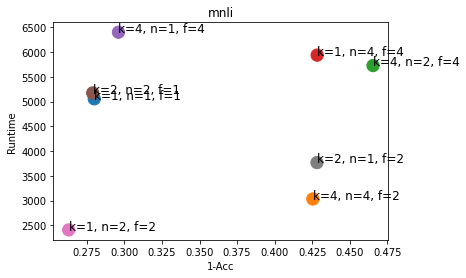

In [35]:
c=0
for dataset in datasets:
    np.random.seed(42)
    acc_list_tailored = np.random.choice(acc_list[dataset], 8, replace=False)
    runtime_list_tailored = np.random.choice(runtime_list[dataset], 8, replace=False)
    labels_tailored = np.random.choice(labels, 8, replace=False)
    print(labels_tailored)
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]
    fig = plt.figure()
    plt.title(f"{dataset}")
    plt.xlabel("1-Acc")
    plt.ylabel("Runtime")
    plt.scatter(1- np.array(acc_list_tailored), np.array(runtime_list_tailored),s=150,color=colors[:len(acc_list_tailored)])
    for idx in range(len(acc_list_tailored)):
        plt.text(1-acc_list_tailored[idx], runtime_list_tailored[idx], labels_tailored[idx], fontsize=12)
    plt.savefig(os.path.join(output_fig_path, f"eval-ablation-{dataset}-sactter-12.03.pdf"))
    c=c+1

In [ ]:
# 直接运行第二个代码块儿，不用运行第一个代码块儿
# 用于画图，画出不同的k，n，f的曲线，不然会有bug